# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

In [ ]:
!pip install -q datasets

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

Let's retrieve the caption of the first example:

In [ ]:
dataset[0]["text"]

And the corresponding image

In [ ]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [39]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

/tmp/ipython-input-4169383787.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/tmp/ipython-input-4169383787.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Epoch 1/5 | step 50 | train_loss(avg50)=2.1184
Epoch 1/5 | step 100 | train_loss(avg50)=2.1226
Epoch 1/5 | step 150 | train_loss(avg50)=2.0402
Epoch 1/5 | step 200 | train_loss(avg50)=2.1251
Epoch 1/5 | step 250 | train_loss(avg50)=2.0582
Epoch 1/5 | step 300 | train_loss(avg50)=2.0800
Epoch 1/5 | step 350 | train_loss(avg50)=2.0489
Epoch 1/5 | step 400 | train_loss(avg50)=2.0886
Epoch 1/5 | step 450 | train_loss(avg50)=2.0177
Epoch 1/5 | step 500 | train_loss(avg50)=2.1440


[VAL] step 500 | BLEU=0.2432 | ROUGE-L=0.5098
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is jumping over a log.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is hanging from a rope.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a child are sitting in a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a

[VAL] step 1000 | BLEU=0.2432 | ROUGE-L=0.5110
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a log.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man is rock climbing.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man in a life vest is paddling a yellow kayak with a child in a life vest.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a yellow

[VAL] step 1500 | BLEU=0.2310 | ROUGE-L=0.4993
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is playing with a large log.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue shirt and black pants is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a boy in a yellow kayak paddles another boy in a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a li

[VAL] step 2000 | BLEU=0.2539 | ROUGE-L=0.5015
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is running across a branch.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket and red helmet is rock climbing.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a boy in a yellow kayak is paddling through the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life

[VAL] step 2500 | BLEU=0.2451 | ROUGE-L=0.5166
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog jumps over a log in the woods.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person wearing a blue jacket is hanging from a rope in the snow.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man in a yellow kayak on a lake.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets 

[VAL] step 3000 | BLEU=0.2468 | ROUGE-L=0.5042
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog sits on top of a fallen tree.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a child in a yellow kayak paddles through the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life

[VAL] step 3500 | BLEU=0.2411 | ROUGE-L=0.4991
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a large branch.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket and skis is hanging from a rope.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a young girl are riding a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets ar

[VAL] step 4000 | BLEU=0.2478 | ROUGE-L=0.4968
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is laying on a large brown dog ' s back in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a young girl in a yellow kayak on the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little 

[VAL] step 4500 | BLEU=0.2320 | ROUGE-L=0.4978
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a brown dog is sitting on a log in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: two people climbing a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a little girl are sitting in a yellow kayak in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are

[VAL] step 5000 | BLEU=0.2245 | ROUGE-L=0.4917
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog jumping over a fallen tree in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is ice climbing.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a child in a yellow canoe float in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jack

[VAL] step 5500 | BLEU=0.2485 | ROUGE-L=0.5057
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is climbing over a fallen tree.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is climbing a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a child are in a yellow kayak in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are 

[VAL] step 6000 | BLEU=0.2427 | ROUGE-L=0.5020
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is standing on a fallen tree.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is hanging from a rope in the snow.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a little girl are kayaking in a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blu

[VAL] step 6500 | BLEU=0.2413 | ROUGE-L=0.4895
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is running over a log in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is climbing a snowy wall.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a woman and a young girl in a yellow kayak float in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blu

[VAL] step 7000 | BLEU=0.2414 | ROUGE-L=0.4999
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and tan dog is jumping over a large stick in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue shirt is climbing a snow - covered mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a child in a yellow kayak in a lake.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy i

[VAL] step 7500 | BLEU=0.2599 | ROUGE-L=0.5037
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is laying on a fallen tree.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket climbs a snow - covered mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a boy and a girl in a yellow kayak ride through the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue li

[VAL] step 8000 | BLEU=0.2473 | ROUGE-L=0.5049
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is laying on a log in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and child float in a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are

[VAL] step 8500 | BLEU=0.2297 | ROUGE-L=0.4879
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog jumps over a fallen tree in a field of green grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man in a yellow kayak paddles through the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in

[VAL] step 9000 | BLEU=0.2259 | ROUGE-L=0.4859
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a log in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is skiing in the snow.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a child are sitting in a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a

[VAL] step 9500 | BLEU=0.2450 | ROUGE-L=0.4942
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a fallen tree.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a woman and a child in a yellow kayak in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets a

[VAL] step 10000 | BLEU=0.2403 | ROUGE-L=0.5018
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is jumping over a log in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is climbing up a snow covered mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a girl are in a yellow kayak in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little bo

[VAL] step 10500 | BLEU=0.2403 | ROUGE-L=0.5058
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a log in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man is kayaking with a dog.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a yell

[VAL] step 11000 | BLEU=0.2391 | ROUGE-L=0.4982
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a fallen tree in the forest.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is climbing up a snowy hill.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a woman and a child are sitting in a yellow canoe on the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in

[VAL] step 11500 | BLEU=0.2258 | ROUGE-L=0.4945
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a fallen tree in the grass.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket is climbing up a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a child in a life jacket in a yellow kayak on blue water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little

[VAL] step 12000 | BLEU=0.2309 | ROUGE-L=0.4948
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog jumps over a log.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket is hanging upside down in the snow.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man holds a paddle in a yellow kayak.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a yellow ca

[VAL] step 12500 | BLEU=0.2058 | ROUGE-L=0.4776
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a fallen tree.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man in a blue jacket climbs up a snowy hill.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a toddler in a yellow kayak ride through the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets ar

[VAL] step 13000 | BLEU=0.2285 | ROUGE-L=0.4873
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is jumping over a large piece of wood.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person wearing a blue jacket is skiing down a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a young boy and a young girl are in a yellow kayak on calm river.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man a

[VAL] step 13500 | BLEU=0.2287 | ROUGE-L=0.4898
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black dog is jumping over a log.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a person in a blue jacket climbs a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a boy and a girl in a kayak ride through the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a yel

[VAL] step 14000 | BLEU=0.2215 | ROUGE-L=0.4877
  sample image: 1015584366_dfcec3c85a.jpg
  pred: a black and white dog is jumping over a log in the woods.
  refs: ['A black dog leaps over a log .', 'A grey dog is leaping over a fallen tree .', 'A large black dog leaps a fallen log .', 'A mottled black and grey dog in a blue collar jumping over a fallen tree .', 'The black dog jumped the tree stump .']
  ---
  sample image: 102455176_5f8ead62d5.jpg
  pred: a man climbs a snowy mountain.
  refs: ['A man uses ice picks and crampons to scale ice .', 'an ice climber in a blue jacket and black pants is scaling a frozen ice wall .', 'An ice climber scaling a frozen waterfall .', 'A person in blue and red ice climbing with two picks .', 'Climber climbing an ice wall']
  ---
  sample image: 1028205764_7e8df9a2ea.jpg
  pred: a man and a dog are in a yellow dinghy in the water.
  refs: ['A man and a baby are in a yellow kayak on water .', 'A man and a little boy in blue life jackets are rowing a

KeyboardInterrupt: 

## Inference

Let's check the results on our train dataset

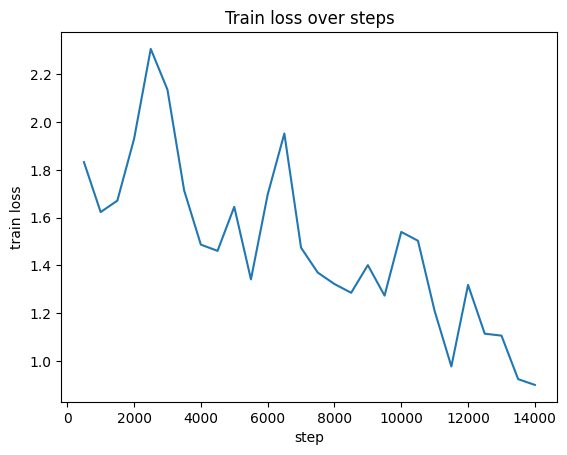

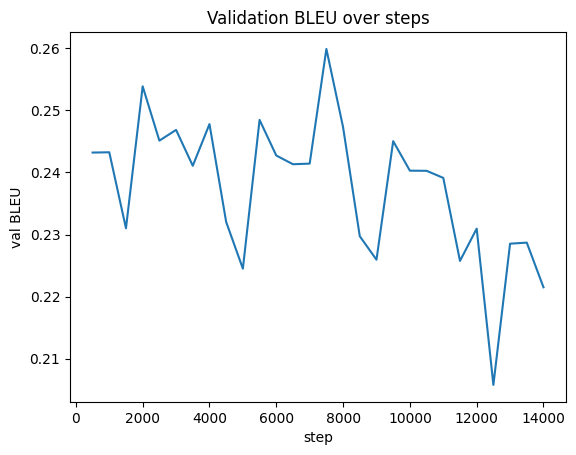

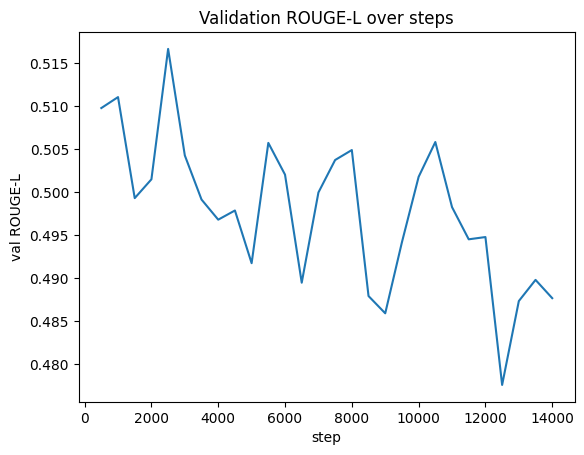

In [40]:
import json
import matplotlib.pyplot as plt

# 保存原始日志（用于结果包）
with open("/content/train_log_history.json", "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=2)

# 可视化：loss vs step
plt.figure()
plt.plot(history["step"], history["train_loss"])
plt.xlabel("step")
plt.ylabel("train loss")
plt.title("Train loss over steps")
plt.show()

# 可视化：BLEU vs step
plt.figure()
plt.plot(history["step"], history["val_bleu"])
plt.xlabel("step")
plt.ylabel("val BLEU")
plt.title("Validation BLEU over steps")
plt.show()

# 可视化：ROUGE-L vs step
plt.figure()
plt.plot(history["step"], history["val_rougeL"])
plt.xlabel("step")
plt.ylabel("val ROUGE-L")
plt.title("Validation ROUGE-L over steps")
plt.show()


In [42]:
# ========= Test: 生成 + BLEU/ROUGE 评估（按图片聚合 5 references）=========
from collections import defaultdict
import evaluate
import torch
from tqdm import tqdm

# 聚合每张图的5条参考caption
img2refs = defaultdict(list)
for _, r in test_df.iterrows():
    img2refs[r["image"]].append(str(r["caption"]))
test_images = list(img2refs.keys())

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

model.eval()

def generate_caption_for_image(img_name, max_new_tokens=30, num_beams=3):
    img_path = os.path.join(IMG_DIR, img_name)
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams
        )
    return processor.decode(out_ids[0], skip_special_tokens=True).strip()

# 为了先快速验证流程，可以先抽样 N 张；最终交作业可设为 None 做全量
N_EVAL = 500
eval_images = test_images[:N_EVAL] if N_EVAL is not None else test_images

predictions = []
references_for_eval = []  # evaluate 的 bleu/rouge：每个样本的 references 传 list[str]

for img_name in tqdm(eval_images, desc="Generating on test"):
    pred = generate_caption_for_image(img_name)
    predictions.append(pred)
    references_for_eval.append(img2refs[img_name])  # 5 refs

# BLEU / ROUGE（ROUGE 会对多reference求平均；BLEU在evaluate里也支持 references=list[list[str]]）
bleu_score = bleu.compute(predictions=predictions, references=references_for_eval)
rouge_score = rouge.compute(predictions=predictions, references=references_for_eval)

print("BLEU:", bleu_score)
print("ROUGE:", rouge_score)

# 打印若干样例便于写报告
for i in range(5):
    img_name = eval_images[i]
    print("\nIMAGE:", img_name)
    print("PRED :", predictions[i])
    print("REFS :", img2refs[img_name])
# ======================================================================


Generating on test: 100%|██████████| 500/500 [03:07<00:00,  2.67it/s]


BLEU: {'bleu': 0.24742307011542677, 'precisions': [0.6654882154882155, 0.3463235294117647, 0.1791497975708502, 0.09076576576576577], 'brevity_penalty': 1.0, 'length_ratio': 1.4673913043478262, 'translation_length': 5940, 'reference_length': 4048}
ROUGE: {'rouge1': np.float64(0.5278559397867517), 'rouge2': np.float64(0.29532682496921137), 'rougeL': np.float64(0.5007369097651236), 'rougeLsum': np.float64(0.5009643966150061)}

IMAGE: 1003163366_44323f5815.jpg
PRED : a woman is sitting on a bench behind a small dog.
REFS : ['A man lays on a bench while his dog sits by him .', 'A man lays on the bench to which a white dog is also tied .', 'a man sleeping on a bench outside with a white and black dog sitting next to him .', 'A shirtless man lies on a park bench with his dog .', 'man laying on bench holding leash of dog sitting on ground']

IMAGE: 1007129816_e794419615.jpg
PRED : a man wearing glasses and a colorful hat.
REFS : ['A man in an orange hat starring at something .', 'A man wears a

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Let's check the results on our train dataset!

In [14]:
# ========= Flickr8k: 本地数据读取 + 按图片划分 train/val/test =========
import os, random
import pandas as pd
from PIL import Image

DATA_ROOT = "/content/flickr8k"   # 改成你自己的根目录
IMG_DIR = os.path.join(DATA_ROOT, "Images")
CAPTION_FILE = os.path.join(DATA_ROOT, "captions.txt")

SEED = 42
random.seed(SEED)

all_images = set(os.listdir(IMG_DIR))

# captions.txt 常见格式：image,caption（逗号分隔）
df = pd.read_csv(CAPTION_FILE, sep=",", header=None, names=["image", "caption"])

# 修正 image 字段到 xxx.jpg（与你作业说明一致）
df["image"] = df["image"].astype(str).apply(lambda x: x.split("jpg")[0] + "jpg")
df["avail"] = df["image"].apply(lambda x: x in all_images)
df = df[df["avail"] == True].dropna(subset=["image", "caption"]).reset_index(drop=True)

# 按“图片级别”划分，避免同一张图泄漏到不同集合
unique_images = df["image"].unique().tolist()
random.shuffle(unique_images)

train_imgs = set(unique_images[:6091])
val_imgs   = set(unique_images[6091:7091])
test_imgs  = set(unique_images[7091:8091])

train_df = df[df["image"].isin(train_imgs)].reset_index(drop=True)
val_df   = df[df["image"].isin(val_imgs)].reset_index(drop=True)
test_df  = df[df["image"].isin(test_imgs)].reset_index(drop=True)

print("train/val/test unique images:", train_df["image"].nunique(), val_df["image"].nunique(), test_df["image"].nunique())
print("train/val/test caption rows :", len(train_df), len(val_df), len(test_df))
# ==============================================================


train/val/test unique images: 6091 1000 1000
train/val/test caption rows : 30455 5000 5000


In [15]:
from torch.utils.data import Dataset, DataLoader

class Flickr8kCaptionDataset(Dataset):
    def __init__(self, df, img_dir, processor, max_length=64):
        self.df = df
        self.img_dir = img_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image"])
        image = Image.open(img_path).convert("RGB")
        caption = str(row["caption"])

        enc = self.processor(
            images=image,
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        enc = {k: v.squeeze(0) for k, v in enc.items()}

        labels = enc["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        enc["labels"] = labels
        return enc


In [16]:
train_dataset = Flickr8kCaptionDataset(train_df, IMG_DIR, processor, max_length=64)
val_dataset   = Flickr8kCaptionDataset(val_df, IMG_DIR, processor, max_length=64)
test_dataset  = Flickr8kCaptionDataset(test_df, IMG_DIR, processor, max_length=64)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, num_workers=2, pin_memory=True)
val_dataloader   = DataLoader(val_dataset, shuffle=False, batch_size=8, num_workers=2, pin_memory=True)
test_dataloader  = DataLoader(test_dataset, shuffle=False, batch_size=8, num_workers=2, pin_memory=True)


NameError: name 'processor' is not defined

In [17]:
import time
import torch
import evaluate
from tqdm import tqdm
from collections import defaultdict

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def build_img2refs(df):
    """把 df 聚合成：image -> [ref1..ref5]"""
    img2refs = defaultdict(list)
    for _, r in df.iterrows():
        img2refs[r["image"]].append(str(r["caption"]))
    return img2refs

val_img2refs = build_img2refs(val_df)
val_images = list(val_img2refs.keys())

def evaluate_on_val(model, processor, img_dir, img2refs, image_list,
                    device, max_eval_images=500, max_new_tokens=30, num_beams=3):
    """
    返回：dict，包含 bleu/rouge（验证指标），以及少量样例
    说明：为加速，默认只评估前 max_eval_images 张图（可设为 None 全量）
    """
    model.eval()

    if max_eval_images is not None:
        image_list = image_list[:max_eval_images]

    preds = []
    refs = []

    for img_name in tqdm(image_list, desc="Val eval", leave=False):
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            out_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_beams=num_beams
            )
        pred = processor.decode(out_ids[0], skip_special_tokens=True).strip()

        preds.append(pred)
        refs.append(img2refs[img_name])   # 多参考（5条）

    bleu = bleu_metric.compute(predictions=preds, references=refs)
    rouge = rouge_metric.compute(predictions=preds, references=refs)

    # 返回少量样例用于日志（可写报告）
    samples = []
    for i in range(min(3, len(image_list))):
        samples.append({
            "image": image_list[i],
            "pred": preds[i],
            "refs": img2refs[image_list[i]]
        })

    return {"bleu": bleu, "rouge": rouge, "samples": samples}

# 训练过程日志（用于可视化/保存）
history = {
    "step": [],
    "train_loss": [],
    "val_bleu": [],      # 记录 bleu["bleu"] 这个主值
    "val_rougeL": [],    # 记录 rouge["rougeL"] 主值
    "timestamp": []
}


ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['rouge_score'] using 'pip install rouge_score' for instance'

In [ ]:
import torch
from transformers import AutoProcessor, BlipForConditionalGeneration

model_name = "Salesforce/blip-image-captioning-base"
processor = AutoProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

train_ds = Flickr8kCaptionDataset(train_df, IMG_DIR, processor, max_length=64)
val_ds   = Flickr8kCaptionDataset(val_df, IMG_DIR, processor, max_length=64)
test_ds  = Flickr8kCaptionDataset(test_df, IMG_DIR, processor, max_length=64)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


In [18]:
!pip install evaluate

import time
import torch
import evaluate
from tqdm import tqdm
from collections import defaultdict

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def build_img2refs(df):
    """把 df 聚合成：image -> [ref1..ref5]"""
    img2refs = defaultdict(list)
    for _, r in df.iterrows():
        img2refs[r["image"]].append(str(r["caption"]))
    return img2refs

val_img2refs = build_img2refs(val_df)
val_images = list(val_img2refs.keys())

def evaluate_on_val(model, processor, img_dir, img2refs, image_list,
                    device, max_eval_images=500, max_new_tokens=30, num_beams=3):
    """
    返回：dict，包含 bleu/rouge（验证指标），以及少量样例
    说明：为加速，默认只评估前 max_eval_images 张图（可设为 None 全量）
    """
    model.eval()

    if max_eval_images is not None:
        image_list = image_list[:max_eval_images]

    preds = []
    refs = []

    for img_name in tqdm(image_list, desc="Val eval", leave=False):
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            out_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_beams=num_beams
            )
        pred = processor.decode(out_ids[0], skip_special_tokens=True).strip()

        preds.append(pred)
        refs.append(img2refs[img_name])   # 多参考（5条）

    bleu = bleu_metric.compute(predictions=preds, references=refs)
    rouge = rouge_metric.compute(predictions=preds, references=refs)

    # 返回少量样例用于日志（可写报告）
    samples = []
    for i in range(min(3, len(image_list))):
        samples.append({
            "image": image_list[i],
            "pred": preds[i],
            "refs": img2refs[image_list[i]]
        })

    return {"bleu": bleu, "rouge": rouge, "samples": samples}

# 训练过程日志（用于可视化/保存）
history = {
    "step": [],
    "train_loss": [],
    "val_bleu": [],      # 记录 bleu["bleu"] 这个主值
    "val_rougeL": [],    # 记录 rouge["rougeL"] 主值
    "timestamp": []
}


ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['rouge_score'] using 'pip install rouge_score' for instance'

In [12]:
!unzip /content/drive/MyDrive/archive.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [11]:
import torch
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 1
LR = 5e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

use_amp = torch.cuda.is_available()
scaler = GradScaler(enabled=use_amp)

eval_every_steps = 500        # 你可以改：比如 200/500/1000
max_val_eval_images = 500     # 为了实时评估速度；最终可设 None 做全量

global_step = 0
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    start_t = time.time()

    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=use_amp):
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        global_step += 1

        # 训练日志（更细粒度可每 N 步写一次）
        if global_step % 250 == 0:
            avg_loss = running_loss / 250
            print(f"Epoch {epoch+1}/{EPOCHS} | step {global_step} | train_loss(avg50)={avg_loss:.4f}")
            running_loss = 0.0

        # ======= 实时验证评估：BLEU / ROUGE =======
        if global_step % eval_every_steps == 0:
            avg_train_loss = loss.item()  # 或你也可以用更平滑的 moving avg
            val_res = evaluate_on_val(
                model=model,
                processor=processor,
                img_dir=IMG_DIR,
                img2refs=val_img2refs,
                image_list=val_images,
                device=device,
                max_eval_images=max_val_eval_images,
                max_new_tokens=30,
                num_beams=3
            )

            # 提取常用主指标
            val_bleu_main = val_res["bleu"]["bleu"] if "bleu" in val_res["bleu"] else None
            val_rougeL_main = val_res["rouge"].get("rougeL", None)

            history["step"].append(global_step)
            history["train_loss"].append(avg_train_loss)
            history["val_bleu"].append(val_bleu_main)
            history["val_rougeL"].append(val_rougeL_main)
            history["timestamp"].append(time.time())

            print(f"[VAL] step {global_step} | BLEU={val_bleu_main:.4f} | ROUGE-L={val_rougeL_main:.4f}")

            # 打印少量样例，便于你写报告的 qualitative 分析
            for s in val_res["samples"]:
                print("  sample image:", s["image"])
                print("  pred:", s["pred"])
                print("  refs:", s["refs"])
                print("  ---")

            model.train()

    epoch_time = time.time() - start_t
    print(f"Epoch {epoch+1} done in {epoch_time/60:.2f} min")


NameError: name 'model' is not defined

In [ ]:
import json
import matplotlib.pyplot as plt

# 保存原始日志（用于结果包）
with open("/content/train_log_history.json", "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=2)

# 可视化：loss vs step
plt.figure()
plt.plot(history["step"], history["train_loss"])
plt.xlabel("step")
plt.ylabel("train loss")
plt.title("Train loss over steps")
plt.show()

# 可视化：BLEU vs step
plt.figure()
plt.plot(history["step"], history["val_bleu"])
plt.xlabel("step")
plt.ylabel("val BLEU")
plt.title("Validation BLEU over steps")
plt.show()

# 可视化：ROUGE-L vs step
plt.figure()
plt.plot(history["step"], history["val_rougeL"])
plt.xlabel("step")
plt.ylabel("val ROUGE-L")
plt.title("Validation ROUGE-L over steps")
plt.show()


In [19]:
# ===================== Hyperparameter Tuning (FAST) =====================
import os, json, time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BlipForConditionalGeneration
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True

# ---------- 1) Metrics helpers ----------
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def build_img2refs(df):
    img2refs = defaultdict(list)
    for _, r in df.iterrows():
        img2refs[r["image"]].append(str(r["caption"]))
    return img2refs

def evaluate_on_val(
    model, processor, img_dir, img2refs, image_list, device,
    max_eval_images=120, max_new_tokens=20, num_beams=1
):
    """
    FAST 评估：
    - max_eval_images 小
    - num_beams=1 (greedy) 更快
    - max_new_tokens 更小
    """
    model.eval()
    if max_eval_images is not None:
        image_list = image_list[:max_eval_images]

    preds, refs = [], []
    for img_name in tqdm(image_list, desc="Val eval", leave=False):
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            out_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_beams=num_beams
            )

        pred = processor.decode(out_ids[0], skip_special_tokens=True).strip()
        preds.append(pred)
        refs.append(img2refs[img_name])

    bleu_raw = bleu_metric.compute(predictions=preds, references=refs)
    rouge_raw = rouge_metric.compute(predictions=preds, references=refs)
    return {
        "bleu_main": float(bleu_raw.get("bleu", np.nan)),
        "rougeL": float(rouge_raw.get("rougeL", np.nan)),
        "bleu_raw": bleu_raw,
        "rouge_raw": rouge_raw
    }

# ---------- 2) Tuning settings ----------
TUNE_OUTDIR = "/content/blip_flickr8k_tuning_fast"
os.makedirs(TUNE_OUTDIR, exist_ok=True)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

use_amp = torch.cuda.is_available()

# 快速调参：固定训练步数，而不是完整 epoch
max_train_steps = 800          # 关键：越小越快（如 300/500/800/1200）
eval_every_steps = 400         # 一次实验评估 1~2 次即可
max_val_eval_images = 120      # 验证图像数越小越快（如 50/80/120）
max_new_tokens_tune = 20       # 更快
num_beams_tune = 1             # greedy 更快（最终 best cfg 可用 3/5）

log_every_steps = 200          # 训练 loss 记录频率

# DataLoader workers：Colab 建议 2~4
num_workers = 2

# （可选）用训练子集加速调参：比如只用 1/5 caption 行
use_train_subset = True
train_subset_ratio = 0.2  # 0.2 = 20% 数据，调参筛选足够快

# 你原来的 search_space 可以保留，但建议少一些组合
search_space = [
    {"lr": 1e-5, "batch_size": 4, "weight_decay": 0.01, "max_length": 64},
    {"lr": 5e-5, "batch_size": 4, "weight_decay": 0.01, "max_length": 64},
    {"lr": 1e-4, "batch_size": 4, "weight_decay": 0.01, "max_length": 64},
    {"lr": 5e-5, "batch_size": 8, "weight_decay": 0.01, "max_length": 64},
]

# 验证集聚合 references
val_img2refs = build_img2refs(val_df)
val_images = list(val_img2refs.keys())

# （可选）构造训练子集
if use_train_subset:
    train_df_tune = train_df.sample(frac=train_subset_ratio, random_state=SEED).reset_index(drop=True)
else:
    train_df_tune = train_df


# ---------- 3) One experiment: train + periodic val ----------
def run_experiment(cfg, processor, model_name, device):
    """
    FAST 实验：
    - 固定 max_train_steps
    - 周期性 val（少量图片、greedy、小 tokens）
    """
    model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

    train_dataset_cfg = Flickr8kCaptionDataset(
        train_df_tune, IMG_DIR, processor, max_length=cfg["max_length"]
    )
    train_loader = DataLoader(
        train_dataset_cfg,
        shuffle=True,
        batch_size=cfg["batch_size"],
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0)
    )

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"]
    )

    scaler = GradScaler(enabled=use_amp)

    history = {"step": [], "train_loss": [], "val_bleu": [], "val_rougeL": []}
    best_bleu, best_rougeL, best_step = -1.0, -1.0, -1

    global_step = 0
    running = 0.0
    t0 = time.time()

    model.train()

    # 关键：不要依赖 epoch，直接循环 dataloader 直到 max_train_steps
    loader_iter = iter(train_loader)
    while global_step < max_train_steps:
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(train_loader)
            batch = next(loader_iter)

        global_step += 1

        input_ids = batch["input_ids"].to(device, non_blocking=True)
        pixel_values = batch["pixel_values"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=use_amp):
            outputs = model(
                input_ids=input_ids,
                pixel_values=pixel_values,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += float(loss.item())

        # 记录 train loss（更稀疏）
        if global_step % log_every_steps == 0:
            avg_loss = running / log_every_steps
            running = 0.0
            history["step"].append(global_step)
            history["train_loss"].append(avg_loss)
            history["val_bleu"].append(None)
            history["val_rougeL"].append(None)

        # 周期性验证（很轻量）
        if global_step % eval_every_steps == 0:
            val_res = evaluate_on_val(
                model=model,
                processor=processor,
                img_dir=IMG_DIR,
                img2refs=val_img2refs,
                image_list=val_images,
                device=device,
                max_eval_images=max_val_eval_images,
                max_new_tokens=max_new_tokens_tune,
                num_beams=num_beams_tune
            )

            val_bleu = float(val_res["bleu_main"])
            val_rougeL = float(val_res["rougeL"])

            history["step"].append(global_step)
            history["train_loss"].append(None)
            history["val_bleu"].append(val_bleu)
            history["val_rougeL"].append(val_rougeL)

            if val_bleu > best_bleu:
                best_bleu, best_rougeL, best_step = val_bleu, val_rougeL, global_step

            model.train()

    elapsed = time.time() - t0

    summary = {
        **cfg,
        "max_train_steps": max_train_steps,
        "eval_every_steps": eval_every_steps,
        "max_val_eval_images": max_val_eval_images,
        "tune_num_beams": num_beams_tune,
        "tune_max_new_tokens": max_new_tokens_tune,
        "best_val_bleu": best_bleu,
        "best_val_rougeL": best_rougeL,
        "best_step": best_step,
        "elapsed_sec": elapsed
    }
    return summary, history


# ---------- 4) Run grid search ----------
all_summaries = []
all_histories = {}

for i, cfg in enumerate(search_space, start=1):
    print(f"\n===== [{i}/{len(search_space)}] Running cfg: {cfg} =====")

    summary, history = run_experiment(
        cfg=cfg,
        processor=processor,
        model_name=model_name,
        device=device
    )

    tag = f"cfg_{i}_lr{cfg['lr']}_bs{cfg['batch_size']}_wd{cfg['weight_decay']}_ml{cfg['max_length']}_steps{max_train_steps}"
    all_summaries.append({"tag": tag, **summary})
    all_histories[tag] = history

    with open(os.path.join(TUNE_OUTDIR, f"{tag}_history.json"), "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False, indent=2)

# 汇总结果表
results_df = pd.DataFrame(all_summaries).sort_values(by="best_val_bleu", ascending=False).reset_index(drop=True)
results_csv = os.path.join(TUNE_OUTDIR, "tuning_results.csv")
results_df.to_csv(results_csv, index=False, encoding="utf-8-sig")

print("\n===== FAST Tuning results (sorted by best_val_bleu) =====")
print(results_df)

best_tag = results_df.loc[0, "tag"]
best_cfg = results_df.loc[0, ["lr","batch_size","weight_decay","max_length"]].to_dict()
print("\nBest cfg (FAST tuning):", best_cfg, "best_tag:", best_tag)


# ---------- 5) Plot comparison curves ----------
def plot_metric_across_cfg(all_histories, metric_key, title):
    plt.figure()
    for tag, hist in all_histories.items():
        xs, ys = [], []
        for s, v in zip(hist["step"], hist[metric_key]):
            if v is not None:
                xs.append(s); ys.append(v)
        if xs:
            plt.plot(xs, ys, label=tag[:45] + "...")
    plt.xlabel("step")
    plt.ylabel(metric_key)
    plt.title(title)
    plt.legend(fontsize=6)
    plt.show()

plot_metric_across_cfg(all_histories, "val_bleu", "FAST tuning: Validation BLEU over steps")
plot_metric_across_cfg(all_histories, "val_rougeL", "FAST tuning: Validation ROUGE-L over steps")

print("\nSaved tuning artifacts to:", TUNE_OUTDIR)
print("Results CSV:", results_csv)

# ===================== End Hyperparameter Tuning (FAST) =====================


ImportError: To be able to use evaluate-metric/rouge, you need to install the following dependencies['rouge_score'] using 'pip install rouge_score' for instance'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")